# Logistic Regression

In [1]:
using MLJ, Effects, MultipleTesting
using GLM, MLJGLMInterface, StableRNGs
import AnovaGLM as aov
include("pubh.jl");

In [2]:
using AlgebraOfGraphics, CairoMakie, MakieThemes
CairoMakie.activate!(type = "svg")
AoG = AlgebraOfGraphics; data = AoG.data
set_theme!(ggthemr(:light))

In [3]:
@rlibrary readr
@rimport pubh

## Univariate Analysis

### Comparing two levels

::: callout-tip
## Example

From Kirkwood & Sterne (Example 19.1). Subjects were classified according to whether they lived in villages in savannah (grassland) or rainforest areas and whether they were infected with Onchocerciasis volvulus or not. The results showed a greater prevalence of microfilariae infection in subjects living in rainforest areas compared to those living in the savannah with an associated odds ratio of 2.41.
:::

In [4]:
R"""
data(Oncho, package="pubh")
oncho = as.data.frame(Oncho)
""";

In [5]:
@rget oncho
oncho |> head

Row,id,mf,area,agegrp,sex,mfload,lesions
,Float64,Cat…,Cat…,Cat…,Cat…,Float64,Cat…
1,1.0,Infected,Savannah,20-39,Female,1.0,No
2,2.0,Infected,Rainforest,40+,Male,3.0,No
3,3.0,Infected,Savannah,40+,Female,1.0,No
4,4.0,Not-infected,Rainforest,20-39,Female,0.0,No
5,5.0,Not-infected,Savannah,40+,Female,0.0,No


::: callout-caution
## Exercise

Perform descriptive statistics that shows the distribution of microfilariae infection (mf) by area of residence.
:::

In [6]:
#| code-fold: true
tabulate(oncho, :mf, :area) |> print

   |              |         area          |       
   |              | Rainforest | Savannah | Total 
--------------------------------------------------
mf | Not-infected |        213 |      267 |   480 
   |     Infected |        541 |      281 |   822 
--------------------------------------------------
   |        Total |        754 |      548 |  1302 


## Logistic Regression Model

For a logistic model, we will use an extension of the multiple linear regression models known as generalised linear models (GLM) using the binomial family (for MLR, we used Gaussian errors).

::: callout-important
For `glm` the outcome/response variable has to be a continuous one; for the case of logistic regression, coded as `0` and `1`.
:::

In [7]:
oncho.mf_cont = coerce(oncho.mf, Continuous) .- 1;

In [8]:
model_1 = glm(@formula(mf_cont ~ area), oncho, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

mf_cont ~ 1 + area

Coefficients:
────────────────────────────────────────────────────────────────────────────
                     Coef.  Std. Error     z  Pr(>|z|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)       0.051106   0.0854637  0.60    0.5498  -0.1164     0.218612
area: Rainforest  0.881021   0.117675   7.49    <1e-13   0.650383   1.11166
────────────────────────────────────────────────────────────────────────────

When we exponentiate, we obtain the Odds Ratio:

In [9]:
exp.(model_1 |> coef)[2] |> r3

2.413

::: callout-note
For univariate analysis of binary outcomes, it's better to use `contingency`:
:::

In [10]:
pubh.contingency(@formula(mf ~ area), data=oncho)

            Outcome
Predictor    Infected Not-infected
  Rainforest      541          213
  Savannah        281          267

             Outcome +    Outcome -      Total                 Inc risk *
Exposed +          541          213        754     71.75 (68.39 to 74.94)
Exposed -          281          267        548     51.28 (47.00 to 55.54)
Total              822          480       1302     63.13 (60.45 to 65.76)

Point estimates and 95% CIs:
-------------------------------------------------------------------
Inc risk ratio                                 1.40 (1.27, 1.54)
Inc odds ratio                                 2.41 (1.92, 3.04)
Attrib risk in the exposed *                   20.47 (15.20, 25.75)
Attrib fraction in the exposed (%)            28.53 (21.56, 34.89)
Attrib risk in the population *                11.86 (6.92, 16.79)
Attrib fraction in the population (%)         18.78 (13.59, 23.65)
-------------------------------------------------------------------
Uncorrected c



	Pearson's Chi-squared test with Yates' continuity correction

data:  dat
X-squared = 56.275, df = 1, p-value = 6.301e-14



RObject{VecSxp}

	Pearson's Chi-squared test with Yates' continuity correction

data:  dat
X-squared = 56.275, df = 1, p-value = 6.301e-14



The default predicted values from a logistic model are probabilities, in our current example, the probability of being infected with *Onchocerciasis volvulus*.

We can use effects to predict the probabilities of being infected by *Onchocerciasis volvulus* when we use the inverse logit transformation:

In [11]:
eff_1 = effects(
	Dict(:area => unique(oncho.area)),
	model_1, invlink=inv_logit
)

Row,area,mf_cont,err,lower,upper
,String,Float64,Float64,Float64,Float64
1,Savannah,0.512774,0.021352,0.491422,0.534126
2,Rainforest,0.717507,0.0163957,0.701111,0.733902


The predicted probabilities can be displayed in an effect plot.

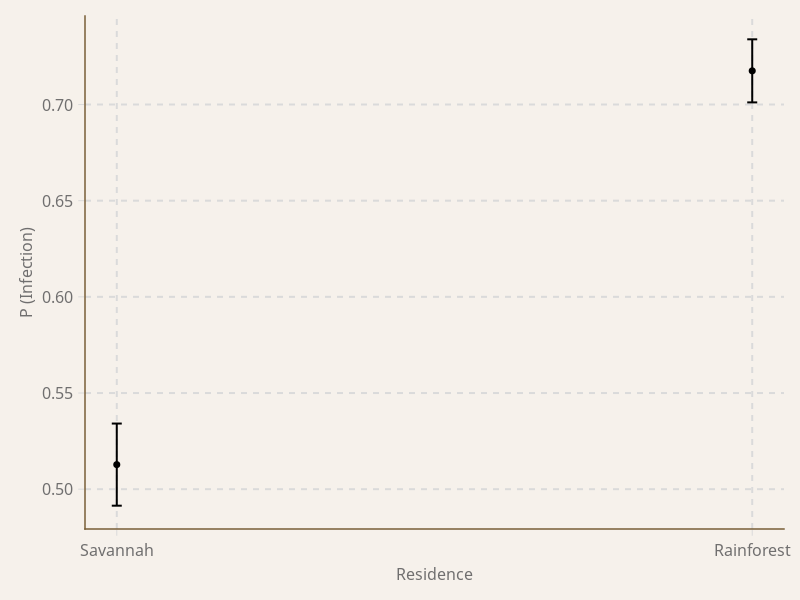

In [12]:
#| label: fig-fig1
#| fig-cap: "Effect of residence on microfilarial infection. Error represents 95% CIs around predicted probabilities."
data(eff_1) *
mapping(
	:area => sorter(unique(oncho.area)) => "Residence",
	:mf_cont => "P (Infection)"
) *
(
	visual(Scatter, markersize=10) +
	mapping(:err) *
	visual(Errorbars, whiskerwidth=10)
) |>
draw

If we divide the deviance by the degrees of freedom we obtain an estimate of the overdispersion of the model. When this value is close to one (less than one, even better), it means that there is no overdispersion.

In [13]:
deviance(model_1) / dof_residual(model_1) |> r3

1.274

### Comparing more than two levels

::: callout-tip
## Example

Now we look at the association between age group and microfilariae infection.
:::

::: callout-caution
## Exercise

Perform descriptive statistics that shows the distribution of microfilariae infection by age group.
:::

In [14]:
#| code-fold: true
tabulate(oncho, :mf, :agegrp)

   |              |          agegrp           |       
   |              | 10-19 | 20-39 | 40+ | 5-9 | Total 
------------------------------------------------------
mf | Not-infected |   119 |   125 |  80 | 156 |   480 
   |     Infected |    99 |   299 | 378 |  46 |   822 
------------------------------------------------------
   |        Total |   218 |   424 | 458 | 202 |  1302 


Next, we fit a logistic linear regression model.

In [15]:
model_2 = glm(@formula(mf_cont ~ agegrp), oncho, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

mf_cont ~ 1 + agegrp

Coefficients:
──────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)    -1.22121    0.167778  -7.28    <1e-12  -1.55005   -0.892376
agegrp: 10-19   1.03721    0.215995   4.80    <1e-05   0.613869   1.46055
agegrp: 20-39   2.09334    0.198731  10.53    <1e-25   1.70384    2.48285
agegrp: 40+     2.77408    0.208074  13.33    <1e-39   2.36626    3.1819
──────────────────────────────────────────────────────────────────────────

In [16]:
r3.(exp.(model_2 |> coef)[2:4])

3-element Vector{Float64}:
  2.821
  8.112
 16.024

In [17]:
eff_2 = effects(
	Dict(:agegrp => levels(oncho.agegrp)),
	model_2, invlink=inv_logit
)

Row,agegrp,mf_cont,err,lower,upper
,String,Float64,Float64,Float64,Float64
1,5-9,0.227723,0.0295062,0.198217,0.257229
2,10-19,0.454128,0.0337215,0.420407,0.48785
3,20-39,0.705189,0.0221433,0.683045,0.727332
4,40+,0.825328,0.0177416,0.807586,0.843069


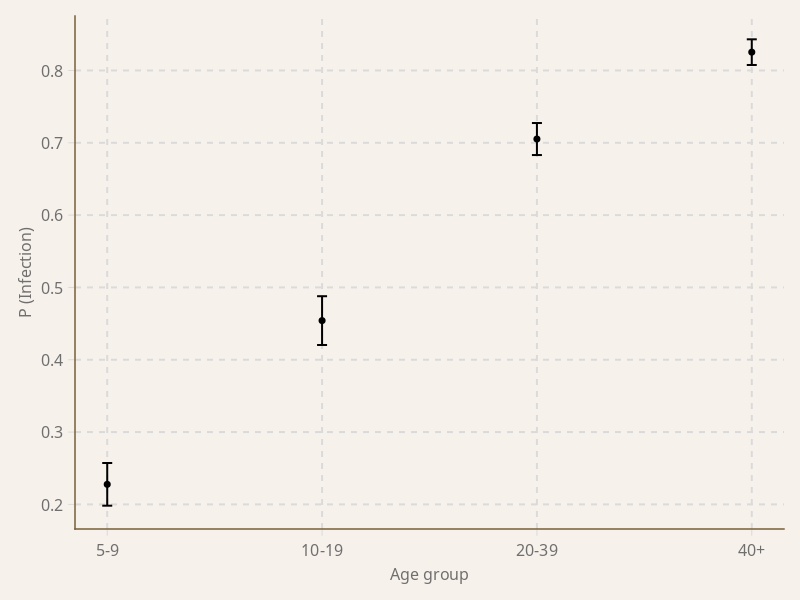

In [18]:
#| label: fig-fig2
#| fig-cap: "Effect of age group on microfilarial infection. Error represents 95% CIs around predicted probabilities."
data(eff_2) *
mapping(
	:agegrp => sorter(levels(oncho.agegrp)) => "Age group",
	:mf_cont => "P (Infection)"
) *
(
	visual(Scatter, markersize=10) +
	mapping(:err) *
	visual(Errorbars, whiskerwidth=10)
) |>
draw

In the case where we really wanted to compare all age groups, we would need to perform a post-hoc analysis adjusting by multiple comparison

In [19]:
BH_adj(pvals) = MultipleTesting.adjust(PValues(pvals), BenjaminiHochberg());

In [20]:
empairs(model_2; dof=dof_residual, padjust=BH_adj)

Row,agegrp,mf_cont,err,dof,t,Pr(>|t|)
,String,Float64,Float64,Float64,Float64,Float64
1,5-9 > 10-19,-1.03721,0.215995,1299.0,-4.80202,2.10362e-6
2,5-9 > 20-39,-2.09334,0.198731,1299.0,-10.5336,1.78005e-24
3,5-9 > 40+,-2.77408,0.208074,1299.0,-13.3322,2.54315e-37
4,10-19 > 20-39,-1.05613,0.172768,1299.0,-6.11301,1.93602e-9
5,10-19 > 40+,-1.73687,0.183439,1299.0,-9.46838,2.579e-20
6,20-39 > 40+,-0.680738,0.162757,1299.0,-4.18253,3.07622e-5


## Mutivariate Analysis

Once we have reproduced the results from the book, let’s make the correct analysis: a multivariate analysis. We will include all potential two-way interactions as our starting model and then proceede to model simplification.

We will start by defining our contrasts for the categorical variables.

In [21]:
oncho_cont = Dict(
	:agegrp => EffectsCoding(),
	:area => EffectsCoding(),
	:sex => EffectsCoding()
);

In [22]:
model_3 = glm(
	@formula(mf_cont ~ agegrp*area + agegrp*sex + area*sex), 
	oncho, Binomial(), LogitLink(),
	contrasts = oncho_cont
)

aov.anova(model_3; type=3)

Analysis of Variance

Type 3 test / Likelihood-ratio test

mf_cont ~ 1 + agegrp + area + sex + agegrp & area + agegrp & sex + area & sex

Table:
─────────────────────────────────────────────────
               DOF  Deviance        χ²  Pr(>|χ²|)
─────────────────────────────────────────────────
(Intercept)      1   1701.08    9.6622     0.0019
agegrp           3   1435.87  265.2054     <1e-56
area             1   1385.21   50.6656     <1e-11
sex              1   1367.83   17.3754     <1e-04
agegrp & area    3   1362.55    5.2849     0.1521
agegrp & sex     3   1356.00    6.5488     0.0878
area & sex       1   1350.36    5.6394     0.0176
─────────────────────────────────────────────────



### Model Simplification

Let’s remove the interaction between area and age group.

In [23]:
model_4 = glm(
	@formula(mf_cont ~ agegrp+area + agegrp*sex + area*sex), 
	oncho, Binomial(), LogitLink(),
	contrasts = oncho_cont
)

aov.anova(model_4; type=3)

Analysis of Variance

Type 3 test / Likelihood-ratio test

mf_cont ~ 1 + agegrp + area + sex + agegrp & sex + area & sex

Table:
────────────────────────────────────────────────
              DOF  Deviance        χ²  Pr(>|χ²|)
────────────────────────────────────────────────
(Intercept)     1   1726.25    7.5626     0.0060
agegrp          3   1449.66  276.5864     <1e-58
area            1   1386.35   63.3184     <1e-14
sex             1   1367.29   19.0591     <1e-04
agegrp & sex    3   1361.23    6.0564     0.1089
area & sex      1   1355.64    5.5860     0.0181
────────────────────────────────────────────────



Let's take a look at the model without the age group and sex interaction.

In [24]:
model_5 = glm(
	@formula(mf_cont ~ agegrp+area + agegrp+sex + area*sex), 
	oncho, Binomial(), LogitLink(),
	contrasts = oncho_cont
)

aov.anova(model_5; type=3)

Analysis of Variance

Type 3 test / Likelihood-ratio test

mf_cont ~ 1 + agegrp + area + sex + area & sex

Table:
───────────────────────────────────────────────
             DOF  Deviance        χ²  Pr(>|χ²|)
───────────────────────────────────────────────
(Intercept)    1   1725.01    7.8006     0.0052
agegrp         3   1449.17  275.8460     <1e-58
area           1   1385.77   63.3921     <1e-14
sex            1   1366.10   19.6711     <1e-05
area & sex     1   1361.70    4.4028     0.0359
───────────────────────────────────────────────



### Model comparisons

Comparing the BIC of the multivariate models:

In [25]:
bic(model_3) |> r3, bic(model_4) |> r3, bic(model_5) |> r3

(1443.591, 1427.361, 1411.902)

Comparing AIC:

In [26]:
aic(model_3) |> r3, aic(model_4) |> r3, aic(model_5) |> r3

(1376.359, 1375.644, 1375.7)

Comparing pseudo-r²:

In [27]:
r2(model_3, :Nagelkerke) |> r3, r2(model_4, :Nagelkerke) |> r3, r2(model_5, :Nagelkerke) |> r3

(0.333, 0.329, 0.324)

::: callout-important
## Interpretation

`model_5` had the lowest BIC, however, `model_4` had both the lowest AIC and the highest r².
:::

In [28]:
import RegressionTables as RT

In [29]:
#| output: asis
RT.regtable(
  model_3, model_4, model_5,
  labels = Dict(
		"area: Rainforest" => "Residence (Rainforest/Savanah)",
		"sex: Female" => "Sex (female/male)",
		"mf_cont" => "Microfilarial infection"
	);
	renderSettings = RT.htmlOutput()
)

<table style="border-collapse:collapse; border:none;border-top:double;border-bottom:double;">
<tbody>
<tr><td style="padding:0.1cm" colspan="100%"></td></tr>
<tr><td>                                 <td colspan="3" style="padding:0.2cm; text-align:center; border-bottom:1px solid;">Microfilarial infection</td> </td></tr>

<tr><td>                                 </td><td style="padding:0.2em; padding-left:0.8em; padding-right:0.8em;">       (1) </td><td style="padding:0.2em; padding-left:0.8em; padding-right:0.8em;">       (2) </td><td style="padding:0.2em; padding-left:0.8em; padding-right:0.8em;">       (3) </td></tr>
<tr style="border-bottom:1px solid"><td style="padding:0.1cm" colspan="100%"></td></tr><tr><td style="padding:0.1cm" colspan="100%"></td></tr>
<tr><td>(Intercept)                      </td><td style="padding:0.2em; padding-left:0.8em; padding-right:0.8em;">   0.235** </td><td style="padding:0.2em; padding-left:0.8em; padding-right:0.8em;">   0.198** </td><td style="paddi

### Effect plots

In [30]:
eff_4 = effects(
	Dict(
		:agegrp => levels(oncho.agegrp),
		:area => levels(oncho.area),
		:sex => levels(oncho.sex)
	),
	model_4, invlink=inv_logit
);

┌ Warning: Keyword argument `bgcolor` is deprecated, use `backgroundcolor` instead.
└ @ Makie /Users/josie/.julia/packages/Makie/RgxaV/src/makielayout/blocks/legend.jl:23


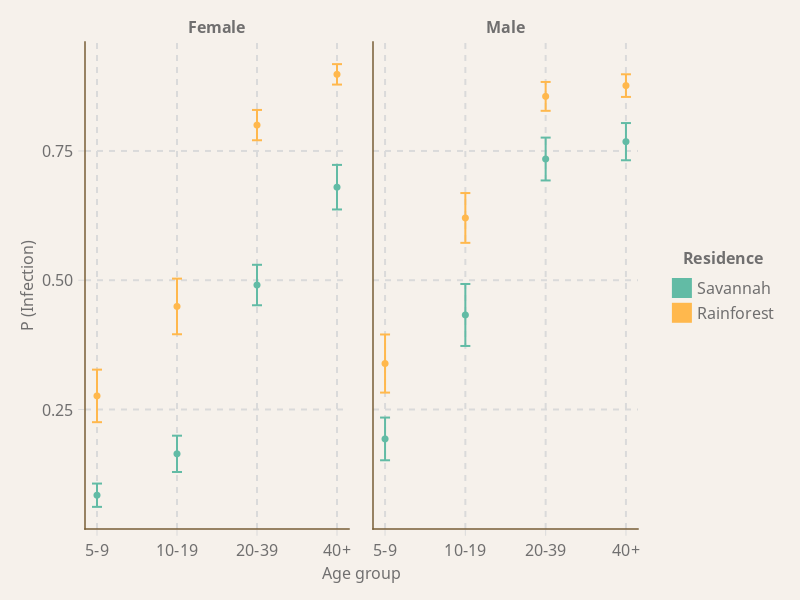

In [31]:
#| label: fig-fig3
#| fig-cap: "Effect of age group on microfilarial infection by residence and sex."
#| warning: false
data(eff_4) *
mapping(
	:agegrp => sorter(levels(oncho.agegrp)) => "Age group",
	:mf_cont => "P (Infection)",
	layout = :sex,
	color = :area => sorter(levels(oncho.area)) => "Residence"
) *
(
	visual(Scatter, markersize=10) +
	mapping(:err) *
	visual(Errorbars, whiskerwidth=10)
) |>
draw

## MLJ Approach

### Pre-processing

In [32]:
@select!(oncho, :mf, :area, :agegrp, :sex);

In [33]:
y, x = unpack(oncho, ==(:mf));

In [34]:
lbc = @load LinearBinaryClassifier pkg=GLM verbosity=0
pipe = 	ContinuousEncoder(drop_last=true) |> lbc

ProbabilisticPipeline(
  continuous_encoder = ContinuousEncoder(
        drop_last = true, 
        one_hot_ordered_factors = false), 
  linear_binary_classifier = LinearBinaryClassifier(
        fit_intercept = true, 
        link = LogitLink(), 
        offsetcol = nothing, 
        maxiter = 30, 
        atol = 1.0e-6, 
        rtol = 1.0e-6, 
        minstepfac = 0.001, 
        report_keys = [:deviance, :dof_residual, :stderror, :vcov, :coef_table]), 
  cache = true)

In [35]:
oncho_mach = machine(pipe, x, y) |> fit!

┌ Info: Training machine(ProbabilisticPipeline(continuous_encoder = ContinuousEncoder(drop_last = true, …), …), …).
└ @ MLJBase /Users/josie/.julia/packages/MLJBase/fEiP2/src/machines.jl:492


┌ Info: Training machine(:continuous_encoder, …).
└ @ MLJBase /Users/josie/.julia/packages/MLJBase/fEiP2/src/machines.jl:492


┌ Info: Training machine(:linear_binary_classifier, …).
└ @ MLJBase /Users/josie/.julia/packages/MLJBase/fEiP2/src/machines.jl:492


trained Machine; does not cache data
  model: ProbabilisticPipeline(continuous_encoder = ContinuousEncoder(drop_last = true, …), …)
  args: 
    1:	Source @573 ⏎ Table{Union{AbstractVector{Multiclass{4}}, AbstractVector{Multiclass{2}}}}
    2:	Source @965 ⏎ AbstractVector{Multiclass{2}}


In [36]:
report(oncho_mach).linear_binary_classifier.coef_table |> print

─────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error       z  Pr(>|z|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
area__Savannah  -1.1227      0.138614   -8.10    <1e-15  -1.39438   -0.85102
agegrp__5-9     -2.87127     0.217113  -13.22    <1e-39  -3.2968    -2.44573
agegrp__10-19   -1.92839     0.194454   -9.92    <1e-22  -2.30951   -1.54726
agegrp__20-39   -0.52348     0.169111   -3.10    0.0020  -0.854932  -0.192027
sex__Male        0.581303    0.135641    4.29    <1e-04   0.315452   0.847153
(Intercept)      1.79698     0.159195   11.29    <1e-28   1.48496    2.10899
─────────────────────────────────────────────────────────────────────────────